## Dram Data Upload

<!--
Assignment Version: 
In this assignment, you'll upload Dram shop data to your GBQ account and run a couple of queries against it. The data for this assignment is in a .csv file callled `items-2022-01-01-2022-10-01.csv`. Save this file into the same folder as this repository. This is an example of item-level reports exported from the point-of-sale system at the Dram shop.

Your goals are to upload this file to a table in a GBQ data set that you create. Call the table `dram_items_2022`. 
As always, make sure _not_ to commit any big data files or API keys to your repo.

Make your data pipeline idempotent, which means you will be checking for the presence of your tables and, if they exist, deleting them before recreating them. 

In this assignment you'll use the `pyjanitor` package, which you can install with `pip install pyjanitor`. Then the `import janitor` call will run. This package, which is modeled on the `janitor` package in R, can be used to clean up names in a data frame. If you have a Pandas data frame called `df`, then `df = janitor.clean_names(df)` will give you nice lowercase names with underscores. You can learn more [here](https://github.com/pyjanitor-devs/pyjanitor). 
--> 

In this exercise, you'll upload Dram shop data to your GBQ account and run a couple of queries against it. The data for this exercise is in a .csv file callled `items-2022-01-01-2022-10-01.csv`. Save this file into the same folder as this repository. This is an example of item-level reports exported from the point-of-sale system at the Dram shop.

Your goals are to upload this file to a table in a GBQ data set that you create. Call the table `dram_items_2022`. 
As always, make sure _not_ to commit any big data files or API keys to your repo.

Make your data pipeline idempotent, which means you will be checking for the presence of your tables and, if they exist, deleting them before recreating them. 

In this assignment you'll use the `pyjanitor` package, which you can install with `pip install pyjanitor`. Then the `import janitor` call will run. This package, which is modeled on the `janitor` package in R, can be used to clean up names in a data frame. If you have a Pandas data frame called `df`, then `df = janitor.clean_names(df)` will give you nice lowercase names with underscores. You can learn more [here](https://github.com/pyjanitor-devs/pyjanitor). 


In [14]:
import os
import re
import datetime 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_gbq
import janitor

# Do our imports for the code
from pandas_gbq import to_gbq
from google.cloud import bigquery
from google.oauth2 import service_account

### GBQ Set Up

In this next section we connect to our GBQ project and list the data sets inside to test the connection.

In [6]:
# These first two values will be different on your machine. 
service_path = "/Users/wiryulemfonbertrand/Desktop/ADA/ex-dram-upload/"
service_file = 'secret-bloom-400923-98901692bc1a.json' # change this to your authentication information  
gbq_proj_id = 'secret-bloom-400923' # change this to your project. 

# And this should stay the same. 
private_key =service_path + service_file

In [3]:
# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(private_key)

In [4]:
# And finally we establish our connection
client = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [5]:
for item in client.list_datasets() : 
    print(item.full_dataset_id)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.no

secret-bloom-400923:dram_exercise


### Checking for and deleting monthly tables

In this section, check for a table with the name `dram_items_2022`. If that table exists, delete it with the `delete_table` function. 

In [16]:
# Your code here

dataset_id = 'dram_exercise'  # Replace with your actual dataset ID
table_id = 'dram_items'

dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)

# Check if the table exists
try:
    client.get_table(table_ref)
    # Table exists, delete it
    client.delete_table(table_ref)
except Exception as e:
    print(f"Table {table_id} not found. Skipping deletion.")

# Now you can proceed with creating the table and uploading your data
# Now you can proceed with creating the table and uploading your data





/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime

### Reading in and modifying data

In this section, read in the data using the Pandas `read_csv` function. Once you've read in the data, make the following modifications to it: 

* Convert the fields that have dollar signs (such as `gross_sales`) into numeric data. Watch out for dollar signs and commas.
* Change the type of the column `modifiers_applied` to string.
* Replace the `sku` column with a column of empty strings. 
* Clean the names with the janitor package.


In [17]:
# Your code here.
# Replace 'your_csv_file_path' with the actual path to your CSV file
csv_file_path = '/Users/wiryulemfonbertrand/Desktop/ADA/ex-dram-upload/items-2022-01-01-2022-10-01.csv'

# Read in the data using pandas
df = pd.read_csv(csv_file_path)

# Print column names to check for existence
print("Original column names:", df.columns)

# Check if columns exist before making modifications
if 'gross_sales' in df.columns:
    # Convert 'gross_sales' to numeric
    df['gross_sales'] = df['gross_sales'].replace(r'[\$,]', '', regex=True).astype(float)

# Check if 'modifiers_applied' exists before changing its type
if 'modifiers_applied' in df.columns:
    # Change the type of 'modifiers_applied' to string
    df['modifiers_applied'] = df['modifiers_applied'].astype(str)

# Check if 'sku' exists before replacing it with empty strings
if 'sku' in df.columns:
    # Replace 'sku' with a column of empty strings
    df['sku'] = ''

# Clean column names with the janitor package
df = df.clean_names()


Original column names: Index(['Date', 'Time', 'Time Zone', 'Category', 'Item', 'Qty',
       'Price Point Name', 'SKU', 'Modifiers Applied', 'Gross Sales',
       'Discounts', 'Net Sales', 'Tax', 'Transaction ID', 'Payment ID',
       'Device Name', 'Notes', 'Details', 'Event Type', 'Location',
       'Dining Option', 'Customer ID', 'Customer Name',
       'Customer Reference ID', 'Unit', 'Count', 'Itemization Type'],
      dtype='object')


/var/folders/26/m6wvyk1x2xs_95n4prqk1v240000gn/T/ipykernel_2721/35434673.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


### Upoad your data to GBQ

Using the Pandas function `to_gbq`, upload your data to GBQ.

In [18]:
# Your code here

# Replace 'your_dataset_id' with your actual dataset ID
dataset_id = 'dram_exercise'
table_id = 'dram_items'

# Upload DataFrame to BigQuery
to_gbq(df, f'{dataset_id}.{table_id}', if_exists='replace', project_id=gbq_proj_id, credentials=credentials)





/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.no

### Query your data

Let's start by counting the rows in your data. Here's an example of how to do that, though you'll need to update the project and data set parameters in the query below. Note that the query inside the triple quotes can just be run the console. 

In [19]:
# Your code here 

query = """
    SELECT COUNT(*)
    FROM `secret-bloom-400923.dram_exercise.dram_items`
"""

results = client.query(query)


for row in results :
    print(f'There were {row[0]} rows.')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.no

There were 110836 rows.


You can also bring results back into a data frame with `pandas_gbq`. 

In [24]:
import pandas_gbq

query = """
    SELECT customer_name, customer_id, SUM(CAST(REPLACE(REPLACE(gross_sales, '$', ''), ',', '') AS FLOAT64)) AS gross_sales
    FROM `secret-bloom-400923.dram_exercise.dram_items`
    WHERE customer_name != ""
    GROUP BY customer_name, customer_id
    ORDER BY gross_sales DESC
"""

# Replace 'your_project_id' with your actual project ID
project_id = 'secret-bloom-400923'

# Execute the query and retrieve results into a DataFrame
df_results = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

# Display the DataFrame
print(df_results)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.no

           customer_name                 customer_id  gross_sales
0       Elizabeth Hunter  HDZVV6GTHH2E5BXBXV8V6SMFJG      2942.90
1           paige pitzer  K6X88Q94W15NF6JE69Z6CZ2PHG      2672.52
2           William Kent  CESZ8TF21N30B5WT0E6GQY50CR      2419.00
3        Jason Whitelock  0VME2ZWWEX24XECG6TB2VNBP94      2163.24
4          Andrew Mozzer  7H2QK5DPRD63ZF5JH2SM7Q5AVW      2059.75
...                  ...                         ...          ...
14502        Riese Munoz  0Y4K1NDJG968FFMYDA9PCABRZM         2.00
14503   Dalton Thunstrom  TKQ3XNVBVS1G58Y68HMCAZB0BW         2.00
14504  Kiavash Adibzadeh  C65ZDV3SF17VEQBAHF0WW9W5YC         2.00
14505     Zachary MIllar  WQGMK8W8Z11YQ5VE970A6VKMC8         1.00
14506       Olivia Olson  HS0CECK4B10PS3PAB4N82JC80C         1.00

[14507 rows x 3 columns]


In [26]:
customer_spend.describe()

Now some additional work for you. Write a query that returns sales by day by category for the Front Street location to a data frame. Call this data frame `daily_category_sales` with columns `date`, `category`, and `gross_sales` (which is the sum of sales for that date and category.

If you've done this correctly, the cells below should run correctly and summarize the data for you and do some plotting. 

In [27]:
# Your code here 

query = """
    SELECT
        date,
        category,
        SUM(CAST(REPLACE(REPLACE(gross_sales, '$', ''), ',', '') AS FLOAT64)) AS gross_sales
    FROM
        `secret-bloom-400923.dram_exercise.dram_items`
    WHERE
        location = 'The Dram Shop Front St.'
        AND customer_name != ""
    GROUP BY
        date, category
"""

# Replace 'your_project_id' with your actual project ID
project_id = 'secret-bloom-400923'

# Execute the query and retrieve results into a DataFrame
daily_category_sales = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

# Display the DataFrame
print(daily_category_sales)




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/api_core/datetime_helpers.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.datetime.utcnow()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/auth/_helpers.py:95: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.no

            date                    category  gross_sales
0     2022-09-17                      F-soda        43.75
1     2022-08-09              Soda - Bottled         1.00
2     2022-04-23              Soda - Bottled         1.00
3     2022-01-06              Soda - Bottled         1.00
4     2022-05-21                        None         1.00
...          ...                         ...          ...
5159  2022-05-06    Sparkling Wine - Bottled       168.00
5160  2022-03-28                   $6 TOKEN!       180.00
5161  2022-06-03  C-Sparkling Wine - Bottles       216.00
5162  2022-04-30    Sparkling Wine - Bottled       230.00
5163  2022-01-13                        None       300.00

[5164 rows x 3 columns]


In [28]:
category_summary = daily_category_sales.groupby('category').sum('gross_sales').nlargest(10,'gross_sales').reset_index()
category_summary

,category,gross_sales
0,F-IPA Draught,85950.75
1,F-Lagers/Pils/Wheat Draught,40085.25
2,F-Wine Draught,25840.50
3,F-Cider Draught,21749.25
4,F-Sour Draught,17977.75
5,F-Amber/Pale Draught,16410.50
6,F-Seasonal,14285.75
7,F-Porter/Stout Draught,11027.50
8,BTG Features!,8585.50
9,Kombucha,7739.25


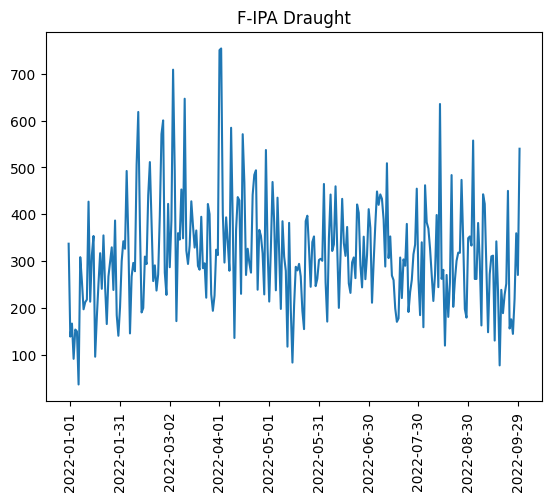

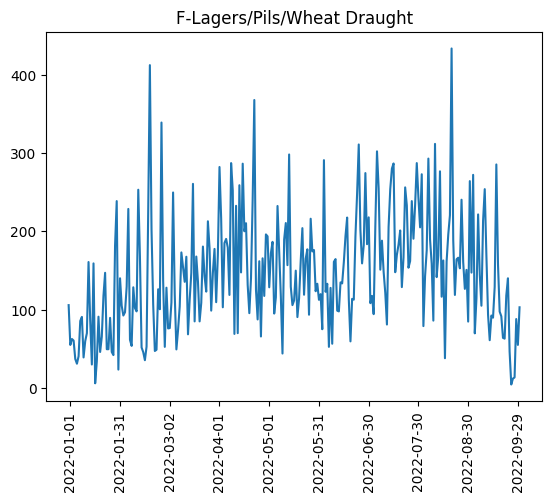

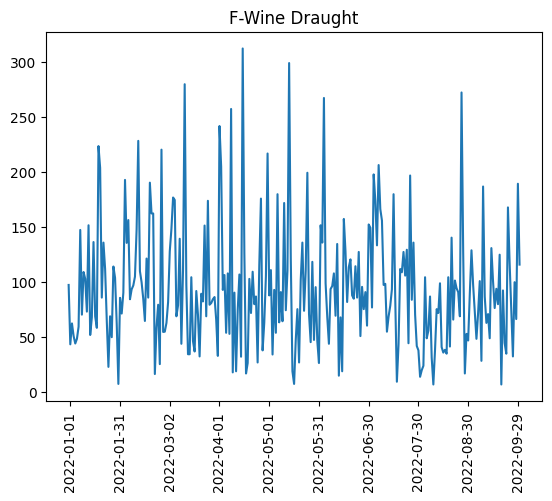

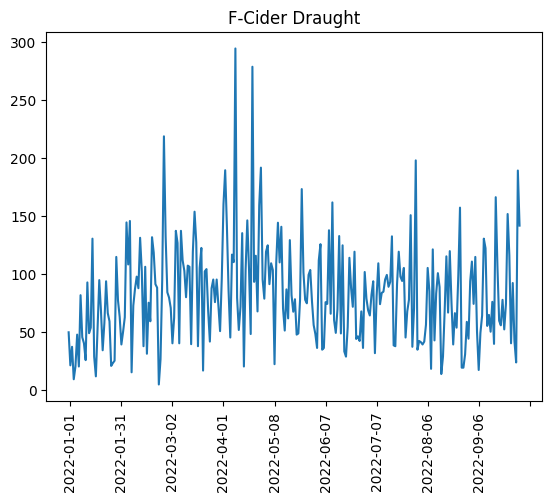

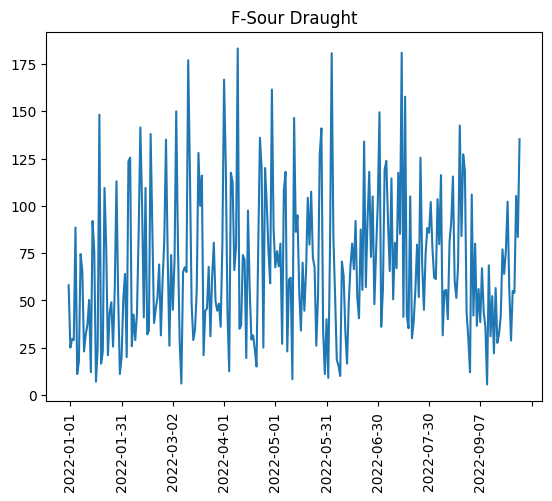

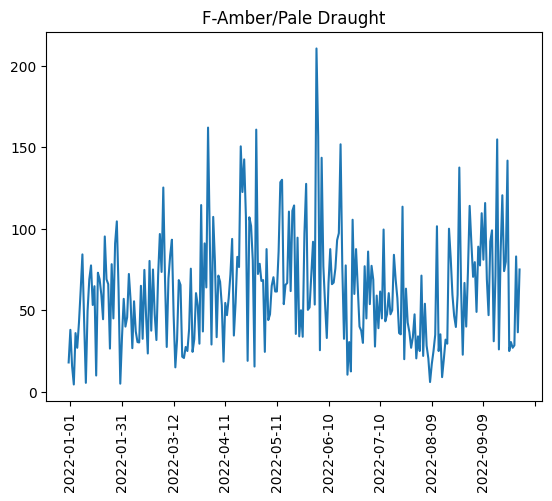

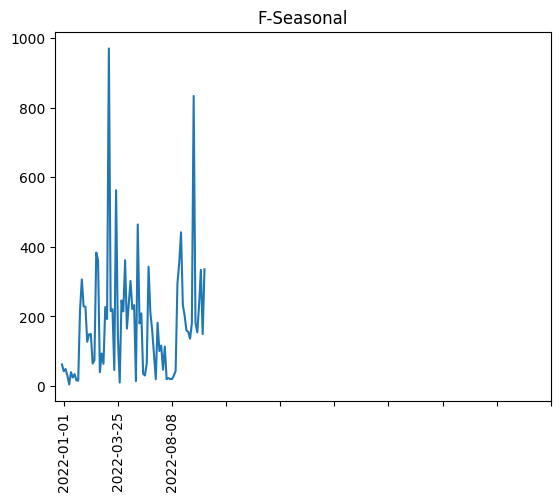

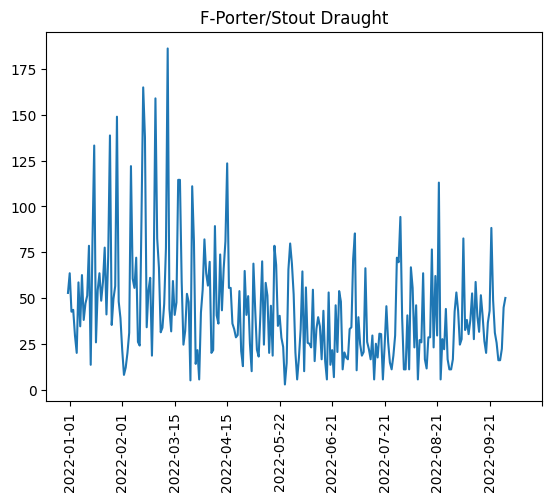

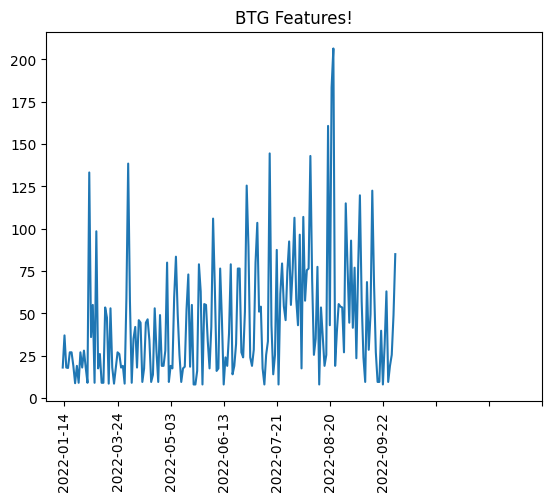

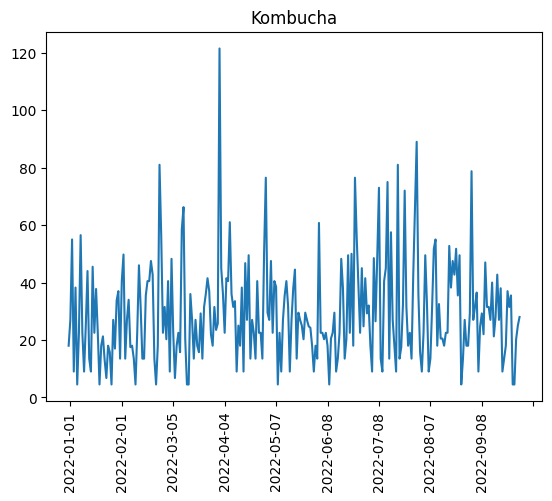

In [29]:
for category in category_summary.category : 
    
    df = daily_category_sales.query(f"category == '{category}'")
    df = df.sort_values('date', ascending=True)
    plt.plot(df['date'], df['gross_sales'])
    plt.xticks(ticks=range(1,300,30),rotation='vertical')
    plt.title(category)
    plt.show()

